In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Datasets/Eyes dataset preprocessed with labels')
print("We are currently in the folder of ",os.getcwd())

We are currently in the folder of  /content/drive/MyDrive/Datasets/Eyes dataset preprocessed with labels


In [ ]:
import pickle
def load_data():
    file = open('df_train_train', 'rb')
    df_train_train = pickle.load(file)
    file.close()

    file = open('df_test', 'rb')
    df_test = pickle.load(file)
    file.close()
    
    return df_train_train, df_test

In [ ]:
df_train_train,df_test = load_data()
print(df_train_train.shape,df_test.shape,'\n')

(2344, 4) (366, 4) 



In [ ]:
df_train_train.head()

,id_code,diagnosis,file_path,file_name
1326,77ab222bf85c,0,dataset/train_images/77ab222bf85c.png,77ab222bf85c.png
300,2f7fbdcc9a4b,0,dataset/train_images/2f7fbdcc9a4b.png,2f7fbdcc9a4b.png
2831,de778495a1cd,2,dataset/train_images/de778495a1cd.png,de778495a1cd.png
328,31616ff6b53b,3,dataset/train_images/31616ff6b53b.png,31616ff6b53b.png
401,370f575adb23,0,dataset/train_images/370f575adb23.png,370f575adb23.png


In [ ]:
df_test.head()

,id_code,diagnosis,file_path,file_name
0,e4dcca36ceb4,0,./dataset/test_images/e4dcca36ceb4.png,e4dcca36ceb4.png
1,e4e343eaae2a,2,./dataset/test_images/e4e343eaae2a.png,e4e343eaae2a.png
2,e4f12411fd85,4,./dataset/test_images/e4f12411fd85.png,e4f12411fd85.png
3,e50b0174690d,0,./dataset/test_images/e50b0174690d.png,e50b0174690d.png
4,e5197d77ec68,0,./dataset/test_images/e5197d77ec68.png,e5197d77ec68.png


In [ ]:
# Model parameters
IMG_SIZE = 512
BATCH_SIZE = 8
#EPOCHS = 40
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = df_train_train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen= ImageDataGenerator(rescale=1./255, validation_split=0.2, horizontal_flip=True)
 
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:

train_generator= train_datagen.flow_from_dataframe(dataframe= df_train_train,
                                                     directory= "/content/drive/MyDrive/Datasets/Eyes dataset preprocessed/train_images_resized_preprocessed",
                                                     x_col= "file_name",
                                                     y_col= "diagnosis",
                                                     batch_size= BATCH_SIZE,
                                                     class_mode= "categorical",
                                                     target_size= (HEIGHT,WIDTH),
                                                     subset= 'training'
                                                     )

Found 1506 validated image filenames belonging to 5 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 462 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
  valid_generator= train_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                      directory="./train_images_resized_preprocessed/",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",    
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='validation')

Found 376 validated image filenames belonging to 5 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 462 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
test_generator = test_datagen.flow_from_dataframe(dataframe= df_test,
                                                    directory= "./test_images_resized_preprocessed/",
                                                    x_col= "file_name", 
                                                    target_size= (HEIGHT, WIDTH),
                                                    batch_size=1,
                                                    shuffle=False,
                                                    class_mode= None
                                                    )

Found 366 validated image filenames.


Model Building 

In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score

from PIL import Image
import cv2

import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation
from keras.callbacks import EarlyStopping,ReduceLROnPlateau



In [ ]:
from tensorflow.keras.applications import ResNet50

In [ ]:
from keras.utils.traceback_utils import include_frame
def create_model(input_shape, n_out):
  input_tensor= Input(shape= input_shape)
  base_model = ResNet50(weights= None, include_top= False, input_tensor= input_tensor)
  base_model.load_weights('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

  x= GlobalAveragePooling2D()(base_model.output)  #It will return the average of feature value instead of sliding over it. 
  x= Dropout(0.5)(x)
  x= Dense(2048, activation='relu')(x)
  x= Dropout(0.5)(x)

  final_output= Dense(n_out, activation='softmax', name= 'final_output')(x)
  model= Model(input_tensor, final_output)

  return model



In [ ]:
# assigning parameters

model= create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out= N_CLASSES)

#Turn off weights 

for layer in model.layers:
  layer.trainable= False

#train 5 layers only 

for i in range(-5,0):
  model.layers[i].trainable= True

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 326, 326, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 160, 160, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size

print(STEP_SIZE_TRAIN)

188


In [ ]:
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print(STEP_SIZE_VALID)

47


In [ ]:
#Compile the model 
from sklearn import metrics
from tensorflow.keras.optimizers import Adam
model.compile(optimizer= Adam(learning_rate= WARMUP_LEARNING_RATE), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
#Fit into the model 

history_warmup = model.fit(train_generator,
                           steps_per_epoch= STEP_SIZE_TRAIN,
                           validation_data= valid_generator,
                           validation_steps=STEP_SIZE_VALID, 
                           epochs= WARMUP_EPOCHS,
                           verbose=1
                           ).history

Epoch 1/2
188/188 [==============================] - 97s 465ms/step - loss: 0.3654 - accuracy: 0.6883 - val_loss: 0.5652 - val_accuracy: 0.4894
Epoch 2/2
188/188 [==============================] - 85s 451ms/step - loss: 0.2463 - accuracy: 0.7370 - val_loss: 0.4376 - val_accuracy: 0.4894


In [ ]:
# Training all the layers 

for layer in model.layers:
  layer.trainable= True

Erl= EarlyStopping(monitor= 'val_loss', mode= 'min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop= ReduceLROnPlateau(monitor= 'val_loss', mode= 'min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)
#rlrop will reduce the learning rate by DECAY_DROP factor

callback_list= [Erl, rlrop]

optimizer= Adam(learning_rate= LEARNING_RATE)
model.compile(optimizer= optimizer, loss= "binary_crossentropy", metrics= ['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 326, 326, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 160, 160, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
history_finetunning= model.fit(train_generator, 
                               steps_per_epoch= STEP_SIZE_TRAIN,
                               validation_data=valid_generator,
                               validation_steps=STEP_SIZE_VALID,
                               epochs= 40,
                               callbacks= callback_list,
                               verbose=1
                               ).history

Epoch 1/40
188/188 [==============================] - 95s 461ms/step - loss: 0.2278 - accuracy: 0.7530 - val_loss: 0.3826 - val_accuracy: 0.5691 - lr: 1.0000e-04
Epoch 2/40
188/188 [==============================] - 85s 453ms/step - loss: 0.2263 - accuracy: 0.7630 - val_loss: 0.3473 - val_accuracy: 0.6090 - lr: 1.0000e-04
Epoch 3/40
188/188 [==============================] - 85s 451ms/step - loss: 0.1980 - accuracy: 0.7937 - val_loss: 0.2577 - val_accuracy: 0.7447 - lr: 1.0000e-04
Epoch 4/40
188/188 [==============================] - 85s 452ms/step - loss: 0.1754 - accuracy: 0.8158 - val_loss: 0.2307 - val_accuracy: 0.7660 - lr: 1.0000e-04
Epoch 5/40
188/188 [==============================] - 85s 453ms/step - loss: 0.1512 - accuracy: 0.8351 - val_loss: 0.2187 - val_accuracy: 0.7979 - lr: 1.0000e-04
Epoch 6/40
188/188 [==============================] - 85s 452ms/step - loss: 0.1297 - accuracy: 0.8578 - val_loss: 0.2553 - val_accuracy: 0.7580 - lr: 1.0000e-04
Epoch 7/40
188/188 [========

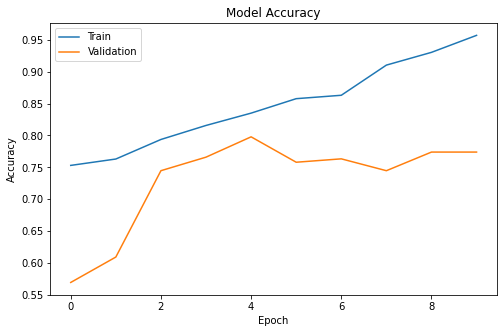

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(history_finetunning['accuracy'])
plt.plot(history_finetunning['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

In [ ]:
#Save the model 

model.save('Diabetic_model.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Datasets/Eyes dataset preprocessed with labels')
print("We are currently in the folder of ",os.getcwd())

We are currently in the folder of  /content/drive/MyDrive/Datasets/Eyes dataset preprocessed with labels


Loading the model 

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Datasets/Eyes dataset preprocessed with labels/Diabetic_model.h5')

Generating Train Prediction on Train data 

In [ ]:
complete_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
complete_generator = complete_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                          directory="./train_images_resized_preprocessed/",
                                                          x_col="file_name",
                                                          target_size= (HEIGHT,WIDTH),
                                                          batch_size=1,
                                                          shuffle= False,
                                                          class_mode=None
                                                          )

STEP_SIZE_COMPLETE= complete_generator.n//complete_generator.batch_size
train_preds = model.predict(complete_generator, steps= STEP_SIZE_COMPLETE, verbose=1)
train_preds= [np.argmax(pred) for pred in train_preds]
print('\n Train Prediction completed', '\n')


Found 1882 validated image filenames.
   3/1882 [..............................] - ETA: 47s 

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 462 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


1882/1882 [==============================] - 44s 23ms/step

 Train Prediction completed 



checking on test data

In [ ]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
test_preds = model.predict(test_generator, steps=STEP_SIZE_TEST,verbose = 1)
test_labels = [np.argmax(pred) for pred in test_preds]

366/366 [==============================] - 109s 299ms/step


In [ ]:
print("Test Accuracy score : %.4f" % accuracy_score(df_test['diagnosis'].astype('int'),test_labels))

Test Accuracy score : 0.8115


In [ ]:
# Accuracy on validation Data 
val_loss, val_accuracy = model.evaluate(valid_generator)


47/47 [==============================] - 7s 114ms/step - loss: 0.2284 - accuracy: 0.7872


In [ ]:
# Printing the validation results
print('Val loss: {0:.4f}. Val accuracy: {1:.2f}%'.format(val_loss, val_accuracy*100.))

Val loss: 0.2284. Val accuracy: 78.72%


In [ ]:
def plot_conf_matrix(true, pred, classes):
  cf = confusion_matrix(true, pred)

  df_cm = pd.DataFrame(cf, range(len(classes)), range(len(classes)))
  plt.figure(figsize=(10,6))
  sns.set(font_scale=1.4)
  sns.heatmap(df_cm, annot= True, annot_kws={'size':16}, xticklabels= classes, yticklabels= classes, fmt='g')
  plt.show()


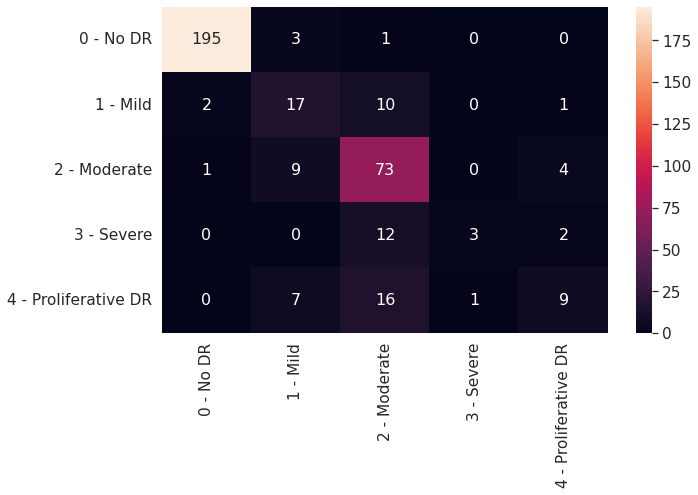

In [ ]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
plot_conf_matrix(list(df_test['diagnosis'].astype(int)),test_labels,labels)

In [ ]:
import keras
import cv2
from keras.models import load_model, Model
import numpy as np
from keras.preprocessing import image

In [ ]:
file_path1= '/content/drive/MyDrive/Datasets/Eyes dataset preprocessed with labels/test_images_resized_preprocessed/e4dcca36ceb4.png' #class0
#file_path2= '/content/drive/MyDrive/Datasets/Eyes dataset preprocessed/test_images_resized_preprocessed/e4e343eaae2a.png' #class2
#file_path3= '/content/drive/MyDrive/Datasets/Eyes dataset preprocessed/test_images_resized_preprocessed/ff8a0b45c789.png' #class4

In [ ]:
img = cv2.imread(file_path1)

In [ ]:
import cv2
imgs = cv2.resize(img, (320,320))

In [ ]:
imgs=image.img_to_array(imgs)
imgs=imgs/255

imgs=np.expand_dims(imgs,axis=0)

In [ ]:
imgs.shape

(1, 320, 320, 3)

In [ ]:
result = model.predict(imgs)

In [ ]:
result

array([[9.9953413e-01, 1.8228437e-05, 4.4741653e-04, 9.5287135e-08,
        1.7162748e-07]], dtype=float32)

In [ ]:
classes1= ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
num_classes = len(classes1)
print (classes1)

['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']


In [ ]:
sorted_prob_idxs = (-result).argsort()[0]

In [ ]:
predicted_prob = np.amax(result)

In [ ]:
predicted_probs= []
predicted_probs.append(predicted_prob)

In [ ]:
predicted_class = classes1[sorted_prob_idxs[0]]

In [ ]:
predicted_classes=[]
predicted_classes.append(predicted_class)

In [ ]:
print (result, '\n')
print("Class Type: ", predicted_class)

[[9.9953413e-01 1.8228437e-05 4.4741653e-04 9.5287135e-08 1.7162748e-07]] 

Class Type:  0 - No DR


In [ ]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']

'''
0 - No DR

1 - Mild

2 - Moderate

3 - Severe

4 - Proliferative DR

'''